# NIH Total Composition

In [ ]:
import os
import random
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import KFold
import h5py
import gc
from itertools import islice
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import itertools
import argparse
import matplotlib.pyplot as plt

In [ ]:
# =============== constants ===============
num_samples = 4567
in_channel = 12046090
each_fold_size = 457   # 10 fold cv
k_fold = 10

# the following are used to normalize data
max_abcd = 3.0
max_label = 5.0
min_label = -5.0

In [ ]:
# =============== input files ===============

combine = pd.read_csv('phenotype_and_GPS.csv', header=0)
combine['KEY'] = combine['KEY'].astype(str)

# process NAN values in labels, I think it's better to process NAN before using the file, instead of procesing it here
combine.fillna(combine.mean(), inplace=True)

#labels = pd.Series(labels_data.nihtbx_fluidcomp_uncorrected.values, index=labels_data.subjectkey).to_dict()


In [ ]:
# =============== parameters ===============
all_layers = [64, 64] # layers in ae, can also be changed to a command line parameter


#initialize with default value
num_epochs = 50
classify_middle = []
m = 16
batch = 50
lr = 0.01
debug = False
use_ae = False
binary_output = False

In [ ]:
if binary_output:
    print('output is binary')
    criterion = nn.CrossEntropyLoss()
else:
    print('output is continuous')
    criterion = nn.MSELoss()

output is continuous


In [ ]:
#x_columns = list(combine.columns.difference(['KEY']))
x_columns = ["AD","DEPRESSION_SUB","IQ","NEUROTICISM","WORRY_SUB","INSOMNIA","PTSD","SNORING","CP","excl23andMe","ADHD","ASD","BIP","SCZ","MDD","ASP","DRINK","RISK4PC","RISKTOL","SMOKER","CANNABIS","GENERALHAPPINESS","GENERALHAPPINESS_HEALTH","GENERALHAPPINESS_MEANINGFUL","HAPPINESS"]
X = pd.DataFrame(combine, columns = x_columns)

Target = 'NIH_totcomp'

y_columns = [Target] # label dimension is 1
y_dim = len(y_columns)
Y = pd.DataFrame(combine, columns = y_columns)
# to test ae binary label
#Y[y_columns[0]] = np.random.randint(2, size=num_samples)

----------------- Use PRS Only -----------------
[Target Output:  NIH_totcomp ]
fold: 0


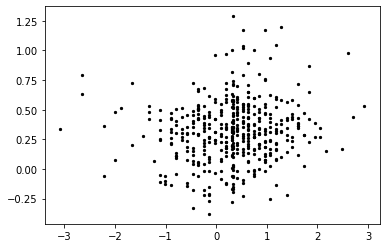

train MSE:  0.11864087793155562
test MSE:  0.6795702366714463
R2 Score:  -0.027581423739883038



fold: 1


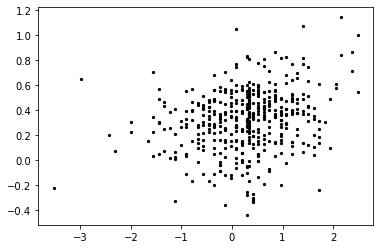

train MSE:  0.12182435315923418
test MSE:  0.65561373224814
R2 Score:  0.05440018603139096



fold: 2


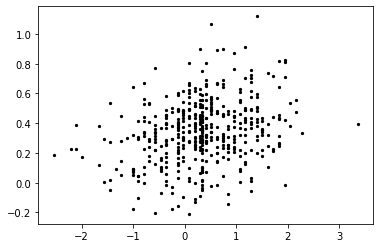

train MSE:  0.11939240975326063
test MSE:  0.6279300271985436
R2 Score:  0.07294095620647911



fold: 3


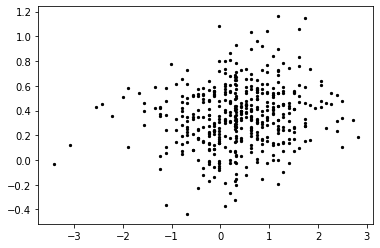

train MSE:  0.11677269559073375
test MSE:  0.7859133785591542
R2 Score:  0.008603014644768758



fold: 4


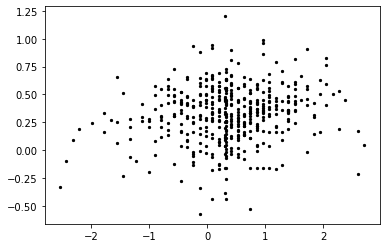

train MSE:  0.12170117350806851
test MSE:  0.6568547476667795
R2 Score:  -0.0007829631817075633



fold: 5


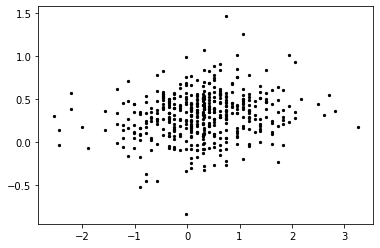

train MSE:  0.12109370300605868
test MSE:  0.6977731492799402
R2 Score:  0.01067008329073682



fold: 6


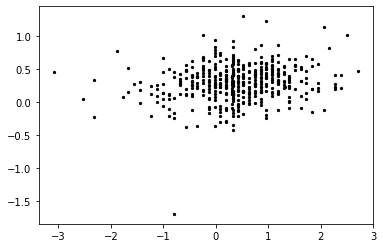

train MSE:  0.12301383507819487
test MSE:  0.6908791026969568
R2 Score:  -0.01220648191410345



fold: 7


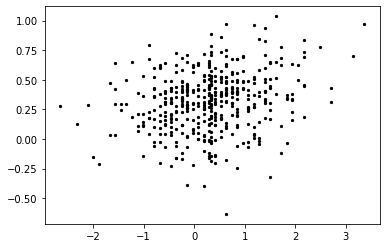

train MSE:  0.12356239584105845
test MSE:  0.6994853450465284
R2 Score:  0.0517525826543086



fold: 8


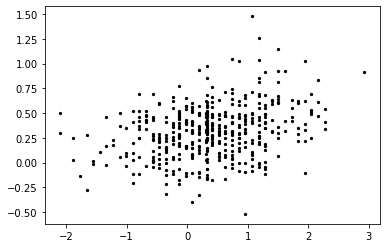

train MSE:  0.12432952263833288
test MSE:  0.6079368039032726
R2 Score:  0.08345761356213555



fold: 9


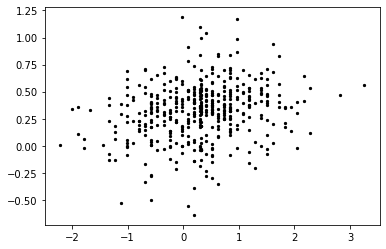

train MSE:  0.12584344559876584
test MSE:  0.6282920351463087
R2 Score:  0.03570818494485528





In [ ]:
print('----------------- Use PRS Only -----------------')
print('[Target Output: ', Target,']')

X = X.to_numpy()
Y = Y.to_numpy().ravel()

# to test binary labels
#Y = np.random.randint(2, size=X.shape[0])

from sklearn.metrics import r2_score

for i in range(k_fold): # 10 folds CV
    print('fold:', i)
    test_index = list(range(i*each_fold_size, min((i+1)*each_fold_size, num_samples)))
    train_index = [i for i in range(num_samples) if i not in test_index]

    if binary_output:
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=2)
        rf_model.fit(X[train_index], Y[train_index])    
        y_pred = rf_model.predict_proba(X[test_index])

        plt.scatter(Y[test_index], y_pred)

    else:
        rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=2)
        rf_model.fit(X[train_index], Y[train_index])
        y_pred_train = rf_model.predict(X[train_index])
        y_pred_test = rf_model.predict(X[test_index])

        plt.scatter(Y[test_index], y_pred_test, s=5, color='black')
        plt.show()
        
        print('train MSE: ',criterion(torch.tensor(y_pred_train), torch.tensor(Y[train_index])).item())
        print('test MSE: ', criterion(torch.tensor(y_pred_test), torch.tensor(Y[test_index])).item())
        print('R2 Score: ', r2_score(Y[test_index], y_pred_test))
    
    print('\n\n')

I expected linear function... 
x-axis: actual nih_totcomp value
y-axis: predicted nih_totcomp value